# Investigating shape FTs in Legume
* Goal: setting up a freeform layer, and having a lattice-shape agnostic FT method for said layer

In [3]:
import numpy as np
import legume
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Text(0.5, 1.0, 'square lattice w/ circle')

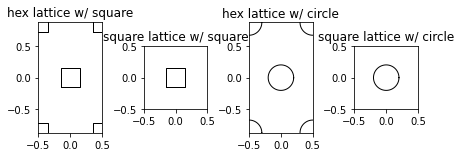

In [5]:
"""
Let's first set up some objects for experimentation
"""
# initialize two different lattice types
h_lattice = legume.Lattice('hexagonal')
s_lattice = legume.Lattice('square')

# create separate layers
#(each lattice type will have one version with circle, one with square)
hex_lattice_w_square = legume.ShapesLayer(h_lattice, eps_b=2)
hex_lattice_w_circle = legume.ShapesLayer(h_lattice, eps_b=2)
squ_lattice_w_square = legume.ShapesLayer(s_lattice, eps_b=2)
squ_lattice_w_circle = legume.ShapesLayer(s_lattice, eps_b=2)

# add shapes
hex_lattice_w_square.add_shape(legume.Square(eps=10, x_cent=0, y_cent=0, a=0.3))
squ_lattice_w_square.add_shape(legume.Square(eps=10, x_cent=0, y_cent=0, a=0.3))
hex_lattice_w_circle.add_shape(legume.Circle(eps=10, x_cent=0, y_cent=0, r=0.2))
squ_lattice_w_circle.add_shape(legume.Circle(eps=10, x_cent=0, y_cent=0, r=0.2))

# visualize current setups
fig, ax = plt.subplots(1, 4)
fig.tight_layout()
legume.viz.shapes(hex_lattice_w_square, ax[0])
ax[0].set_title('hex lattice w/ square')
legume.viz.shapes(squ_lattice_w_square, ax[1])
ax[1].set_title('square lattice w/ square')
legume.viz.shapes(hex_lattice_w_circle, ax[2])
ax[2].set_title('hex lattice w/ circle')
legume.viz.shapes(squ_lattice_w_circle, ax[3])
ax[3].set_title('square lattice w/ circle')

(2, 49)
(2, 25)


Text(0.5, 1.0, 'gvecs (square)')

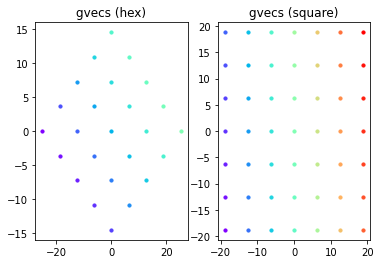

In [6]:
"""
Here, we want to confirm that for a given lattice and gmax, the gvecs will be the same
(i.e. the square and circle hex lattice gvecs will be the same)
"""
gmax = 3

hex_pwe_w_square = legume.PlaneWaveExp(hex_lattice_w_square, gmax=gmax)
hex_pwe_w_circle = legume.PlaneWaveExp(hex_lattice_w_circle, gmax=gmax)
assert np.allclose(hex_pwe_w_square.gvec, hex_pwe_w_circle.gvec)

squ_pwe_w_square = legume.PlaneWaveExp(squ_lattice_w_square, gmax=gmax)
squ_pwe_w_circle = legume.PlaneWaveExp(squ_lattice_w_circle, gmax=gmax)

print(squ_pwe_w_square.gvec.shape)
print(hex_pwe_w_square.gvec.shape)

if squ_pwe_w_square.gvec.shape == hex_pwe_w_square.gvec.shape:
    assert not np.allclose(squ_pwe_w_square.gvec, hex_pwe_w_square.gvec)
assert np.allclose(squ_pwe_w_square.gvec, squ_pwe_w_circle.gvec)


# setup visualization of the vectors
fig, ax = plt.subplots(1, 2)
color = plt.cm.rainbow(np.linspace(0, 1, squ_pwe_w_square.gvec.shape[1]))

for i, c in zip(range(hex_pwe_w_square.gvec.shape[1]), color):
    ax[0].scatter(hex_pwe_w_square.gvec[0][i],hex_pwe_w_square.gvec[1][i], color=c, s=10)
#     ax[0].arrow(0, 0, hex_pwe_w_square.gvec[0][i], hex_pwe_w_square.gvec[1][i], color=c)
ax[0].set_title('gvecs (hex)')
for i, c in zip(range(squ_pwe_w_square.gvec.shape[1]), color):
    ax[1].scatter(squ_pwe_w_square.gvec[0][i], squ_pwe_w_square.gvec[1][i], color=c, s=10)
#     ax[1].arrow(0, 0, squ_pwe_w_square.gvec[0][i], squ_pwe_w_square.gvec[1][i], color=c)
ax[1].set_title('gvecs (square)')

Next, we want to confirm the relationship between gmax and the amplitude of gvectors. Let's first look at the code, then confirm via some assert statements:

Define:

b1, b2 as the primitive vectors such that every reciprocal lattice vector can be written as m * b1 + n * b2 (m, n integers)

gmax as the max reciprocal lattice wave-vector length

We observe the following:
1. gmax does not DIRECTLY determine the number of gvectors. See for example above (square and hexagonal lattices have different numbers of gvectors). This is kind of confusing and should be further visited.

2. gmax determines the max lengths along the b1 and b2 vectors, and determines how many steps along each vector we can use for our simulation. These steps are (n1max, n2max). nimax = 2 * pi * gmax/bi. Note that the longer bi, the smaller nimax (i.e. we can go fewer steps along longer vectors, such that total length remains approximately the same)

3. We can get the number of gvectors as (2 * n1max + 1)(2 * n2max + 1), with n1 max and n2 max defined as above. The full equation becomes: len(gvec) = (2 * floor(2 * pi * gmax / b1) + 1)(2 * floor(2 * pi* gmax/b2) + 1)

4. For m in [-n1max, n1max], for n in [-n2max, n2max], the gvecs along which we project results are G = m * g1 + n * g2

In [8]:
"""
Let's quickly test these relationships to make sure that we're right about them

1. Maximum length of all vectors can be determined by gmax and the angle between b1 and b2
   (by the cosine law)
2. We can deduce the number of gvectors with:
   len(gvec) = (floor(4*pi*gmax/b1) + 1)(floor(4*pi*gmax/b2) + 1)
"""
# 1. Max length of vector
def theta(v, w): return np.arccos(v.dot(w)/(np.linalg.norm(v)*np.linalg.norm(w)))
theta_hex = 180 - theta(h_lattice.b1, h_lattice.b2)
theta_squ = 180 - theta(s_lattice.b1, s_lattice.b2)

l_max_hex = np.sqrt(2 * (2 * np.pi * gmax)**2 - 2 * np.cos(theta_hex)*(2 * np.pi * gmax)**2)
l_max_squ = np.sqrt(2 * (2 * np.pi * gmax)**2 - 2 * np.cos(theta_squ)*(2 * np.pi * gmax)**2)

hex_string = f'(hex) Max possible norm gvec {l_max_hex}, max actual norm: {np.max(np.linalg.norm(hex_pwe_w_square.gvec, axis=0))}'
squ_string = f'(squ) Max possible norm gvec {l_max_squ}, max actual norm: {np.max(np.linalg.norm(squ_pwe_w_square.gvec, axis=0))}'

assert np.all(np.linalg.norm(hex_pwe_w_square.gvec, axis=0) < l_max_hex), hex_string
assert np.all(np.linalg.norm(hex_pwe_w_square.gvec, axis=0) < l_max_squ), squ_string

print(hex_string)
print(squ_string)

# 2. Predict number of gvectors
gvec_num_hex = (2 * np.int_(2 * np.pi * gmax / np.linalg.norm(h_lattice.b1)) + 1) * (2 * np.int_(2 * np.pi * gmax / np.linalg.norm(h_lattice.b2)) + 1)
gvec_num_squ = (2 * np.int_(2 * np.pi * gmax / np.linalg.norm(s_lattice.b1)) + 1) * (2 * np.int_(2 * np.pi * gmax / np.linalg.norm(s_lattice.b2)) + 1)

assert gvec_num_hex == hex_pwe_w_square.gvec.shape[1], print(f'Expected number of gvec: {gvec_num_hex}, actual: {hex_pwe_w_square.gvec.shape[1]}')
assert gvec_num_squ == squ_pwe_w_square.gvec.shape[1], print(f'Expected number of gvec: {gvec_num_squ}, actual: {squ_pwe_w_square.gvec.shape[1]}')

(hex) Max possible norm gvec 37.633539125384544, max actual norm: 25.132741228718345
(squ) Max possible norm gvec 35.77596688572384, max actual norm: 26.657297628950197


In [ ]:
"""
Let's confirm the same with photonic crystals (PHC class)
"""
